## Base de Dados
A base de dados conta com registros de partidas profissionais de Dota 2, contendo o número de identificador de cada personagem selecionado e a taxa de vitória desse personagem selecionado.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# variável usada para remover warnings do jupyter notebook
import warnings
warnings.filterwarnings('ignore')

# leitura e transformação do arquivo em dataframe
dados = pd.read_csv('dadospartidaspro.csv')
dados = dados.drop_duplicates()

dados = dados.drop(columns=['Unnamed: 0', 'id', 'rank1', 'rank2', 'rank3', 'rank4', 'rank5', 'rank6', 'rank7', 'rank8', 
                            'rank9', 'rank10'])
dados['winner'] = dados['winner'].apply(lambda item: 1 if item == 'radiant' else 0)
dados

,winner,pick1,taxavitoria1,pick2,taxavitoria2,pick3,taxavitoria3,pick4,taxavitoria4,pick5,...,pick6,taxavitoria6,pick7,taxavitoria7,pick8,taxavitoria8,pick9,taxavitoria9,pick10,taxavitoria10
0,1,103,48.71,137,47.80,40,56.34,53,38.84,86,...,52,46.11,106,52.82,32,47.60,51,49.86,89,54.47
1,0,48,53.33,11,46.33,128,47.00,110,47.69,85,...,30,45.32,100,50.84,45,46.77,105,38.84,53,51.87
2,0,54,46.68,120,45.35,69,43.66,123,46.02,58,...,18,48.71,65,47.70,96,51.74,86,49.88,91,51.34
3,0,136,47.02,74,48.71,108,49.49,10,45.52,86,...,43,50.69,100,48.13,46,45.32,75,52.01,53,38.84
4,1,85,53.33,25,46.33,128,42.92,129,46.54,70,...,6,51.39,22,47.69,137,47.80,110,47.90,5,45.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382,1,126,48.22,87,49.85,96,47.70,109,47.31,11,...,121,48.26,69,46.68,63,48.55,138,48.06,89,54.47
1383,1,73,51.31,33,49.16,85,53.33,96,47.70,21,...,68,51.28,75,52.01,129,42.92,8,46.56,106,49.86
1384,1,104,54.35,126,48.22,75,52.01,5,51.39,70,...,111,53.48,106,49.86,136,49.49,91,49.88,73,51.31
1385,0,73,51.31,94,54.30,90,49.96,2,50.44,59,...,62,53.93,14,49.12,86,48.71,87,49.85,120,50.21


## Escolha do Melhor Algoritmo
Para a escolha do melhor algoritmo foram utilizados de diversos algoritmos explorados na literatura, de forma que foi calculado sua acurácia e sua precisão. O algoritmo com melhor precisão foi escolhido e a partir disso feito um ajuste dos parâmetros para determinar a melhor precisão possível para o problema.

Melhor Algoritmo Escolhido:
Precisão e Acurácia:
Precisão e Acurácia depois do Ajuste de Parâmetros:

### Funções Auxiliares
Para auxiliar nos cálculos necessários de verificação dos algoritmos foram desenvolvidas algumas funções que realizam o cálculo e impressão das métricas, separação do conjunto de teste, entre outras questões, como por exemplo salvar os dados no framework MLFlow, que facilitou a leitura a verificação dos melhores resultados.

In [2]:
import mlflow
import mlflow.sklearn
import os

# função auxiliar para criar um experimento no mlflow
def criarExperimento():
    # variáveis de conexão com o mlflow
    os.environ['MLFLOW_TRACKING_URI'] = "https://dagshub.com/stardotwav/Dota2Predictor.mlflow"
    os.environ['MLFLOW_TRACKING_USERNAME'] = "stardotwav"
    os.environ['MLFLOW_TRACKING_PASSWORD'] = "7dcb76dec399290fb3a125d02a9a7b39e2c03d90"
    
    mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_URI'])
    mlflow.set_experiment(experiment_name='Personagens Selecionados e Taxa de Vitória')

    tags = {
            "Projeto": "Projeto de Engenharia de Aprendizado de Máquina",
            "team": "Estela",
            "dataset": "dota2teamsprofessionals"
           }

In [3]:
# função auxiliar que salva os dados no MLFlow
def modelosMLFlow(acuracia, modelo, nomeModelo):
    with  mlflow.start_run(run_name=nomeModelo):
        # registro das métricas
        mlflow.log_metric("Acurácia", acuracia)
        
        # registro do modelo
        mlflow.sklearn.log_model(modelo, "Modelo")
        mlflow.end_run()

In [4]:
# import utilizado para realizar a separação do treino e teste
from sklearn.model_selection import train_test_split

# função auxiliar que realiza a separação do dataset em treino e teste
def separacaoModelo(dataset, target):
    X = dataset.drop(target, axis=1)
    Y = dataset[target]
    xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    return xTrain, xTest, yTrain, yTest

In [5]:
# import de algoritmos utilizados
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# função auxiliar que gerar qualquer modelo de acordo com seu nome
def gerarModelo(xTrain, xTest, yTrain, yTest, modelo):
    md = modelo
    md.fit(xTrain, yTrain)
    pred = md.predict(xTest)
    
    return md, pred

In [6]:
# import do cross_validation
from sklearn.model_selection import cross_val_score

# grafico que gera comparação entre diversos algoritmos
def graficoComparacao(algoritmos, nomes, x, y):
    scores = {}
    cont = 0
    for i in algoritmos:
        scores[nomes[cont]] = cross_val_score(i, x, y, cv=30)
        cont += 1

    scores = pd.DataFrame.from_dict(scores)
    plt.figure(figsize = (15,10))
    sns.set(font_scale=1.8)
    sns.boxplot(data=scores, palette='rocket')

No experimento foi utilizado dos algoritmos:

In [7]:
# gerando base de dados
xTrain, xTest, yTrain, yTest = separacaoModelo(dados, 'winner')

In [8]:
# criando experimento
criarExperimento()

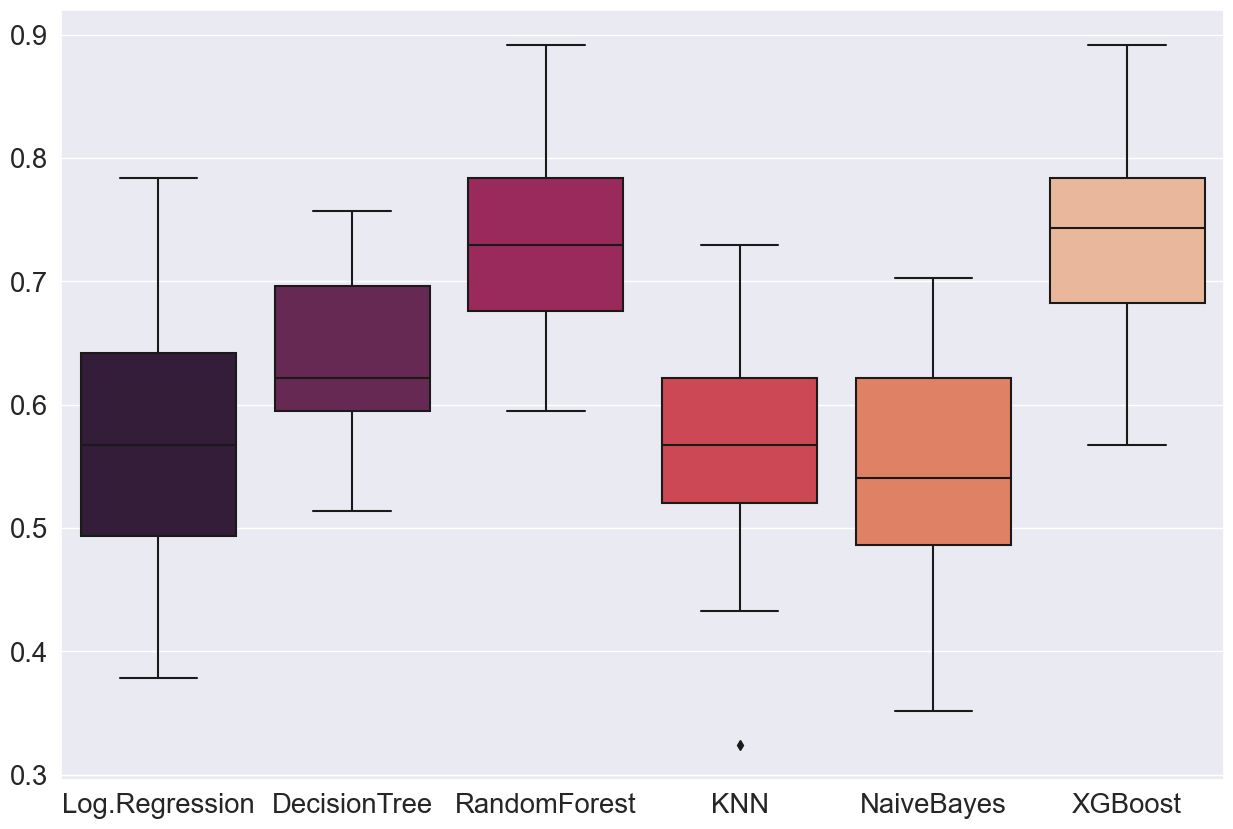

In [11]:
algoritmos = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier(), GaussianNB(), XGBClassifier()]
nomes = ['Log.Regression', 'DecisionTree', 'RandomForest', 'KNN', 'NaiveBayes', 'XGBoost']

# gerando graficos de comparacao, usando do treino e do teste
graficoComparacao(algoritmos, nomes, xTrain, yTrain)

### Decision Tree

In [10]:
# imports necessário
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

# parâmetros que serão aleatoriezados
parameters = {'criterion': ['entropy', 'gini'], 'max_depth': [None, 50, 100], 'min_samples_split': [2, 4, 6],
              'max_features': ['auto', 'sqrt', 'log2']}

# classificador usado
dt = DecisionTreeClassifier(random_state=42)

# geração do gridsearch
clf = GridSearchCV(estimator=dt, param_grid=parameters, scoring='precision', cv=10)
clf.fit(xTrain, yTrain)
#clf.cv_results_

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 50, 100],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 6]},
             scoring='precision')

In [11]:
# melhores parâmetros
clf.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2}

In [12]:
# melhor score
clf.best_score_

0.6248066304406683

In [13]:
modelosMLFlow(clf.best_score_, dt, "Decision Tree")

In [35]:
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=None, min_samples_split=2)
dt.fit(xTrain, yTrain)
pred = dt.predict(xTest)
acuracia = accuracy_score(yTest, pred)
print(f'Acurácia: {acuracia}')

Acurácia: 0.7158273381294964


### Logistic Regression

In [14]:
# parâmetros que serão aleatoriezados
parameters = {'penalty': ['l1', 'l2', 'elasticnet'] 'tol': [0.0001, 0.001, 0.01, 0.0004, 0.004]}

# classificador usado
lr = LogisticRegression()

# geração do gridsearch
clf = GridSearchCV(estimator=lr, param_grid=parameters, scoring='precision', cv=10)
clf.fit(xTrain, yTrain)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'dual': [True, False],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'tol': [0.0001, 0.001, 0.01, 0.0004, 0.004]},
             scoring='precision')

In [15]:
# melhores parâmetros
clf.best_params_

{'dual': False, 'penalty': 'l2', 'tol': 0.0001}

In [16]:
# melhor score
clf.best_score_

0.557083573954591

In [17]:
modelosMLFlow(clf.best_score_, lr, "Logistic Regression")

In [36]:
dt = LogisticRegression(penalty='l2', tol=0.0001)
dt.fit(xTrain, yTrain)
pred = dt.predict(xTest)
acuracia = accuracy_score(yTest, pred)
print(f'Acurácia: {acuracia}')

Acurácia: 0.5071942446043165


### KNN

In [18]:
# parâmetros que serão aleatoriezados
parameters = {'n_neighbors': [5, 10, 15, 20], 'algorithm': ['auto', 'brute', 'kd_tree', 'ball_tree'], 
              'metric': ['cosine', 'euclidean', 'manhattan', 'minkowski']}

# classificador usado
knn = KNeighborsClassifier()

# geração do gridsearch
clf = GridSearchCV(estimator=knn, param_grid=parameters, scoring='precision', cv=10)
clf.fit(xTrain, yTrain)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'brute', 'kd_tree', 'ball_tree'],
                         'metric': ['cosine', 'euclidean', 'manhattan',
                                    'minkowski'],
                         'n_neighbors': [5, 10, 15, 20]},
             scoring='precision')

In [19]:
# melhores parâmetros
clf.best_params_

{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 20}

In [20]:
# melhor score
clf.best_score_

0.5614053792158691

In [21]:
modelosMLFlow(clf.best_score_, knn, "KNN")

In [37]:
dt = KNeighborsClassifier(algorithm='auto', metric='manhattan', n_neighbors=20)
dt.fit(xTrain, yTrain)
pred = dt.predict(xTest)
acuracia = accuracy_score(yTest, pred)
print(f'Acurácia: {acuracia}')

Acurácia: 0.539568345323741


### Naive Bayes

In [22]:
# parâmetros que serão aleatoriezados
parameters = {'priors': [None, [0.1,]*10],
            'var_smoothing': [1e-9, 1e-6, 1e-12]}

# classificador usado
nb = GaussianNB()

# geração do gridsearch
clf = GridSearchCV(estimator=nb, param_grid=parameters, cv=10)
clf.fit(xTrain, yTrain)

GridSearchCV(cv=10, estimator=GaussianNB(),
             param_grid={'priors': [None,
                                    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
                                     0.1, 0.1]],
                         'var_smoothing': [1e-09, 1e-06, 1e-12]})

In [23]:
# melhores parâmetros
clf.best_params_

{'priors': None, 'var_smoothing': 1e-09}

In [24]:
# melhor score
clf.best_score_

0.5491564291564293

In [25]:
modelosMLFlow(clf.best_score_, nb, "Naive Bayes")

In [38]:
dt = GaussianNB(priors=None, var_smoothing=1e-09)
dt.fit(xTrain, yTrain)
pred = dt.predict(xTest)
acuracia = accuracy_score(yTest, pred)
print(f'Acurácia: {acuracia}')

Acurácia: 0.5359712230215827


### Random Forest

In [30]:
# parâmetros que serão aleatoriezados
parameters = {'n_estimators': [50, 100, 200], 'criterion': ['entropy', 'gini'],
              'max_depth': [None, 50, 100], 'min_samples_split': [2, 4, 6],
              'max_features': ['auto', 'sqrt', 'log2'], 'bootstrap': [True, False]}

# classificador usado
rf = RandomForestClassifier(random_state=42)

# geração do gridsearch
clf = GridSearchCV(estimator=rf, param_grid=parameters, cv=10)
clf.fit(xTrain, yTrain)
#clf.cv_results_

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 50, 100],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 100, 200]})

In [31]:
# melhores parâmetros
clf.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 200}

In [32]:
# melhor score
clf.best_score_

0.7421703521703522

In [34]:
modelosMLFlow(clf.best_score_, rf, "Random Forest")

In [5]:
from sklearn.metrics import accuracy_score

dt = RandomForestClassifier(random_state=42, bootstrap=False, criterion='gini', max_depth=None, min_samples_split=2, n_estimators=200)
dt.fit(xTrain, yTrain)
pred = dt.predict(xTest)
acuracia = accuracy_score(yTest, pred)
print(f'Acurácia: {acuracia}')

Acurácia: 0.7266187050359713


<Axes: >

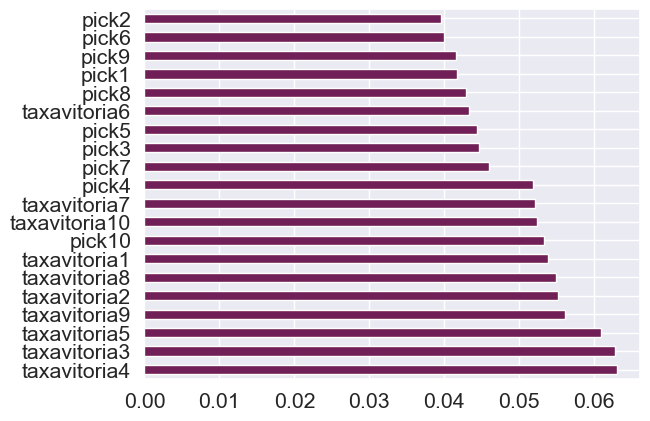

In [6]:
# Create a series containing feature importances from the model and feature names from the training data
sns.set(font_scale=1.4)
feature_importances = pd.Series(dt.feature_importances_, index=xTrain.columns).sort_values(ascending=False)

# Plot a simple bar chart
sns.set_style('darkgrid')
feature_importances.plot(kind='barh', color='#701f57')

### XGBoost

In [12]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

# parâmetros que serão aleatoriezados
parameters = {'max_depth': [6, 8, 10], 'alpha': [10, 20, 30], 'learning_rate': [0.6, 0.8, 1.0]}

# classificador usado
xgb = XGBClassifier()

# geração do gridsearch
clf = GridSearchCV(estimator=xgb, param_grid=parameters, cv=10)
clf.fit(xTrain, yTrain)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'alpha': [10, 20, 30],
                         'learning_rate': [0.6, 0.8, 1.0],
                         'max_depth': [6, 8, 10]})

In [13]:
# melhores parâmetros
clf.best_params_

{'alpha': 10, 'learning_rate': 0.8, 'max_depth': 8}

In [14]:
# melhor score
clf.best_score_

0.6393366093366094

In [15]:
modelosMLFlow(clf.best_score_, xgb, "XGBoost")

In [16]:
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(alpha=10, learning_rate=0.6, max_depth=10)
xgb.fit(xTrain, yTrain)
pred = xgb.predict(xTest)
acuracia = accuracy_score(yTest, pred)
print(f'Acurácia: {acuracia}')

Acurácia: 0.6294964028776978
